In [65]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np

In [5]:
df = pd.read_csv(r'../Finalized Data/finalized_data.csv')

In [6]:
df.columns

Index(['elect', 'military', 'APD', 'Prof', 'female', 'CC', 'SC-AJ', 'SC',
       'SC-AJ & SC', 'start year',
       ...
       'type_crime_welfare fraud', 'type_crime_nan', 'degree_crime_fifth',
       'degree_crime_first', 'degree_crime_fourth', 'degree_crime_second',
       'degree_crime_seventh', 'degree_crime_sixth', 'degree_crime_third',
       'degree_crime_nan'],
      dtype='object', length=284)

In [51]:
df.head(5)

,elect,military,APD,Prof,female,CC,SC-AJ,SC,SC-AJ & SC,start year,...,type_crime_welfare fraud,type_crime_nan,degree_crime_fifth,degree_crime_first,degree_crime_fourth,degree_crime_second,degree_crime_seventh,degree_crime_sixth,degree_crime_third,degree_crime_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [63]:
df.shape

(35232, 284)

<b> Make Design Matrix X and target variable y, and split the dataset into train and test </b>

In [7]:
y = df['Y']
X = df.loc[:, df.columns != 'Y']

For KNN, it is better to normalize all columns to get rid of large scale.

In [110]:
normalized_X = preprocessing.normalize(X)
X_Normalized = pd.DataFrame(normalized_X, columns = X.columns)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_Normalized, y, test_size=0.3,random_state=42)

<b> First KNN model with K = 3 </b>

In [97]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)
# fitting the model
knn.fit(X_train, y_train)
# predict the response
pred = knn.predict(X_test)
# evaluate accuracy
print (accuracy_score(y_test, pred))

0.766792809839


<b> Tunning parameters to get better result </b>

In [98]:
# creating odd list of K for KNN
myList = list(range(1,70))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 31


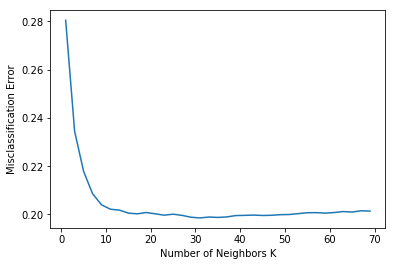

In [99]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [159]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=31)
# fitting the model
knn.fit(X_train, y_train)
# predict the response
pred = knn.predict(X_test)
# evaluate accuracy

In [160]:
#print("Optimal neighbor is %s" % (optimal_k))
print("Accuracy: %s" % (accuracy_score(y_test, pred)))

Accuracy: 0.799810785241


<b> Feature Selection </b>

In [104]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [105]:
def AUCCal(preds, truth, label_string):
   
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
   
    return roc_auc    


In [114]:
#Check auc scores for all features
featureset = list(X_train.columns.values)
feature_auc_dict = {}

#create a plot and set some options
for col in X_train.columns:
    feature_auc_dict[col] = AUCCal(X_train[col],y_train,col)

In [115]:
#calculate mi for each feature 
feature_mi = mutual_info_classif(X_train,y_train)
feature_mi_dict = dict(zip(X_train.columns.values, feature_mi))

#Add auc and mi each to a single dataframe
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_mi = pd.DataFrame(pd.Series(feature_mi_dict), columns = ['mi'])   

#Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_mi, left_index = True, right_index = True)


In [116]:
feat_imp_df.sort_values(by=['auc'],ascending=False).head(10)

,auc,mi
Gap_days,0.653188,0.079943
start year,0.647671,0.040718
judge_info_missing,0.640803,0.089863
judge_SC_missing,0.633145,0.082909
judge_SC-AJ_missing,0.633145,0.083167
judge_SC-AJ & SC_missing,0.633145,0.082132
judge_CC_missing,0.633145,0.081432
judge_female_missing,0.632733,0.081783
judge_law_school_missing,0.630381,0.087263
judge_startyear_missing,0.628618,0.083444


In [117]:
feat_imp_df.sort_values(by=['mi'],ascending=False).head(10)

,auc,mi
judge_info_missing,0.640803,0.089863
judge_law_school_missing,0.630381,0.087263
judge_startyear_missing,0.628618,0.083444
judge_SC-AJ_missing,0.633145,0.083167
judge_SC_missing,0.633145,0.082909
judge_SC-AJ & SC_missing,0.633145,0.082132
judge_female_missing,0.632733,0.081783
type_crime_nan,0.622416,0.081524
judge_CC_missing,0.633145,0.081432
degree_crime_nan,0.617256,0.080247


    Try features with auc rank

In [118]:
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)

In [161]:
accuracy = []
for f in range(10,290,10):
    featureset_1_auc = list(feat_ranks[(feat_ranks.auc <= f)].index.values)
    X_train_2 = X_train[featureset_1_auc]
    X_test_2 = X_test[featureset_1_auc]
    
    # instantiate learning model (k = 3)
    knn = KNeighborsClassifier(n_neighbors=31)
    # fitting the model
    knn.fit(X_train_2, y_train)
    # predict the response
    pred = knn.predict(X_test_2)
    # evaluate accuracy
    accuracy.append(accuracy_score(y_test, pred))

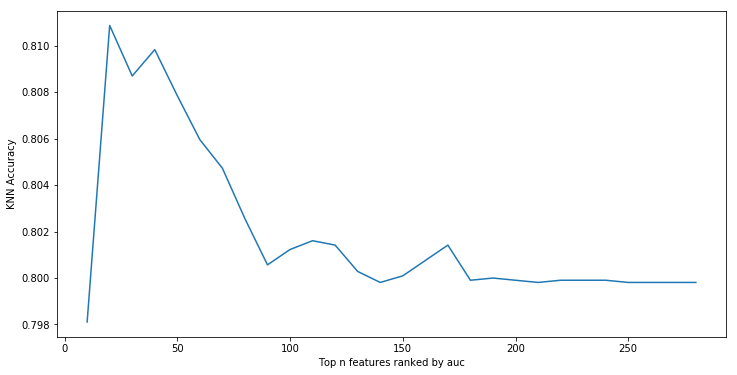

In [162]:
#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

f = np.arange(10,290,10)
plt.plot(f,accuracy)
plt.xlabel("Top n features ranked by auc")
plt.ylabel("KNN Accuracy")
plt.show()

In [163]:
optimal_f = f[accuracy.index(max(accuracy))]
optimal_feature_auc = featureset_1_auc = list(feat_ranks[(feat_ranks.auc <= optimal_f)].index.values)
print("Optimal feature list ranked by AUC is top %s" % (optimal_f) )
print("Optimal feature list ranked by AUC is %s" % (optimal_feature_auc))
print("Accuracy:%s" % (max(accuracy)))

Optimal feature list ranked by AUC is top 20
Optimal feature list ranked by AUC is ['Gap_days', 'SC-AJ', 'defense__nan', 'degree_crime_nan', 'judge_APD_missing', 'judge_CC_missing', 'judge_Prof_missing', 'judge_SC-AJ & SC_missing', 'judge_SC-AJ_missing', 'judge_SC_missing', 'judge_elect_missing', 'judge_female_missing', 'judge_info_missing', 'judge_law_school_missing', 'judge_military_missing', 'judge_startyear_missing', 'nycourts', 'start year', 'type_crime_nan', 'unanimous']
Accuracy:0.810879848628


    Try feature with mi score rank

In [164]:
accuracy_3 = []
for f in range(10,290,10):
    featureset_1_mi = list(feat_ranks[(feat_ranks.mi <= f)].index.values)
    X_train_3 = X_train[featureset_1_mi]
    X_test_3 = X_test[featureset_1_mi]
    
    # instantiate learning model (k = 3)
    knn = KNeighborsClassifier(n_neighbors=31)
    # fitting the model
    knn.fit(X_train_3, y_train)
    # predict the response
    pred = knn.predict(X_test_3)
    # evaluate accuracy
    accuracy_3.append(accuracy_score(y_test, pred))

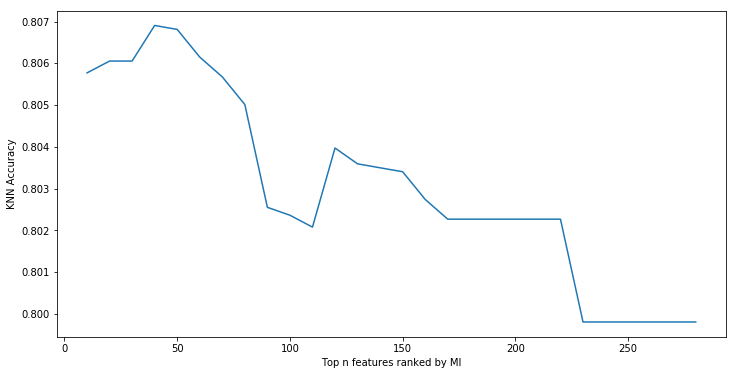

In [165]:
#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

f = np.arange(10,290,10)
plt.plot(f,accuracy_3)
plt.xlabel("Top n features ranked by MI")
plt.ylabel("KNN Accuracy")
plt.show()

In [166]:
optimal_f_mi = f[accuracy_3.index(max(accuracy_3))]
optimal_feature_mi = featureset_1_auc = list(feat_ranks[(feat_ranks.mi <= optimal_f_mi)].index.values)
print("Optimal feature list ranked by MI is top %s" % (optimal_f_mi) )
print("Optimal feature list ranked by MI is %s" % (optimal_feature_mi) )
print("Accuracy:%s" % (max(accuracy_3)))

Optimal feature list ranked by MI is top 40
Optimal feature list ranked by MI is ['AppealD_2015', 'AppealD_month_x', 'AppealD_month_y', 'FirstD_month_x', 'FirstD_month_y', 'Gap_days', 'SC-AJ', 'a_Friday', 'a_Monday', 'a_Tuesday', 'a_Wednesday', 'appellant', 'contested_nan', 'da_2005', 'da_2009', 'da_2013', 'da_black_nan', 'da_female_nan', 'da_university_nan', 'defense__nan', 'degree_crime_nan', 'election_nan', 'f_Monday', 'f_Tuesday', 'judge_APD_missing', 'judge_CC_missing', 'judge_Prof_missing', 'judge_SC-AJ & SC_missing', 'judge_SC-AJ_missing', 'judge_SC_missing', 'judge_elect_missing', 'judge_female_missing', 'judge_info_missing', 'judge_law_school_missing', 'judge_military_missing', 'judge_startyear_missing', 'nycourts', 'start year', 'type_crime_nan', 'unanimous']
Accuracy:0.806906338694


<b> PCA to decomposition </b>

In [91]:
from sklearn.decomposition import PCA

In [95]:
pca = PCA(n_components=140)
X_PCA = pca.fit_transform(X)